# Does SF gene expression explain exon inclusion?

In [1]:
import os
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
import gc
import seaborn as sns
import matplotlib.pyplot as plt

# variables
dataset_re_oi = "LIHC" # ipsc_differentiation, LIHC
dataset_gt_oi = "ENCOREKD"
cell_line_gt_oi = "HepG2"
gene_oi_symbol = "SF3B1"
gene_oi_ensembl = "ENSG00000115524"

# main paths
ROOT = os.path.dirname(os.path.dirname(os.getcwd()))
RAW_DIR = os.path.join(ROOT,"data","raw")
PREP_DIR = os.path.join(ROOT,"data","prep")
SUPPORT_DIR = os.path.join(ROOT,"support")
RESULTS_DIR = os.path.join(ROOT,"results","validation_activity")

# regulators
regulators_oi_file = os.path.join(SUPPORT_DIR,"splicing_factors","splicing_factors-ensembl.txt")

# reverse engineering
re_genexpr_file = os.path.join(PREP_DIR,"genexpr_tpm","{dataset}.tsv.gz").format(dataset=dataset_re_oi)
re_psi_file = os.path.join(PREP_DIR,"event_psi","{dataset}-EX.tsv.gz").format(dataset=dataset_re_oi)
re_metadata_file = os.path.join(PREP_DIR,"metadata","{dataset}.tsv.gz").format(dataset=dataset_re_oi)

# ground truth
gt_metadata_file = os.path.join(PREP_DIR,"metadata","{dataset}.tsv.gz").format(dataset=dataset_gt_oi)
gt_psi_file = os.path.join(PREP_DIR,"event_psi","{dataset}-EX.tsv.gz").format(dataset=dataset_gt_oi)
gt_genexpr_file = os.path.join(PREP_DIR,"genexpr_tpm","{dataset}.tsv.gz").format(dataset=dataset_gt_oi)
gt_fc_genexpr_file = os.path.join(PREP_DIR,'ground_truth_pert','{dataset}',"{cell_line}",'log2_fold_change_tpm.tsv.gz').format(dataset=dataset_gt_oi, cell_line=cell_line_gt_oi)
gt_delta_psi_file = os.path.join(PREP_DIR,'ground_truth_pert','{dataset}',"{cell_line}",'delta_psi-EX.tsv.gz').format(dataset=dataset_gt_oi, cell_line=cell_line_gt_oi)
gt_regulons_file = os.path.join(RESULTS_DIR,"files","subsetted_regulons","regulons_selected","{dataset}_{cell_line}-dpsi_morethan_15.tsv.gz").format(dataset=dataset_gt_oi, cell_line=cell_line_gt_oi)

In [2]:
# load data
regulators_oi = pd.read_table(regulators_oi_file, header=None)[0].tolist()
re_metadata = pd.read_table(re_metadata_file)
re_genexpr = pd.read_table(re_genexpr_file, index_col=0)
re_psi = pd.read_table(re_psi_file, index_col=0)

gt_metadata = pd.read_table(gt_metadata_file)
gt_genexpr = pd.read_table(gt_genexpr_file, index_col=0)
gt_psi = pd.read_table(gt_psi_file, index_col=0)
gt_fc_genexpr = pd.read_table(gt_fc_genexpr_file, index_col=0)
gt_delta_psi = pd.read_table(gt_delta_psi_file, index_col=0)
gt_regulons = pd.read_table(gt_regulons_file)

gc.collect()

0

In [3]:
# make sure sample order is the same
common_samples = set(re_psi.columns).intersection(re_genexpr.columns)
re_psi = re_psi[common_samples].copy()
re_genexpr = re_genexpr[common_samples].copy()

#for IPSCs take only neuronal dataset
if dataset_re_oi=="ipsc_differentiation":
    samples_oi = re_metadata.loc[re_metadata["study_accession"]=="PRJNA596331","run_accession"]
    re_psi = re_psi[samples_oi].copy()
    re_genexpr = re_genexpr[samples_oi].copy()

## True exon targets tend to have higher association coefficients

In [4]:
# compute spearman correlations between SF genexpr and exon PSI
idx_regulators = re_genexpr.index.isin(regulators_oi)
corrs = re_psi.iloc[:20000].corrwith(re_genexpr.loc[gene_oi_ensembl], method="spearman", axis=1)

/home/miquel/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


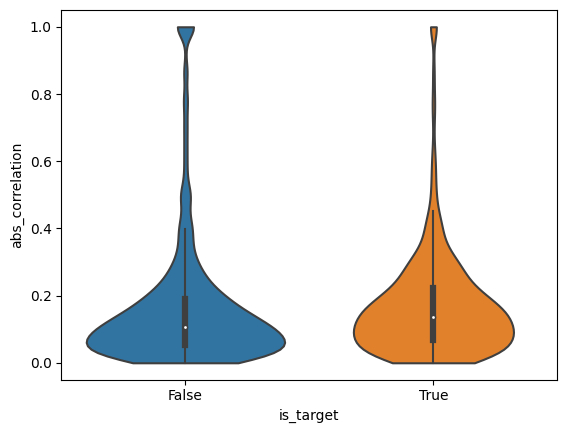

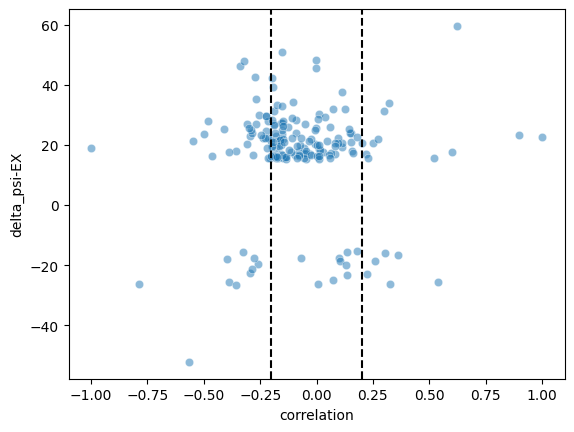

In [5]:
X = corrs.reset_index().rename(columns={0:"correlation"})
X["is_target"] = X["EVENT"].isin(gt_regulons["target"])
X["abs_correlation"] = np.abs(X["correlation"])
X = pd.merge(X, gt_regulons.loc[gt_regulons["GENE"]==gene_oi_symbol, ["EVENT","delta_psi-EX"]], on="EVENT", how="left")
X["delta_psi-EX"] = -X["delta_psi-EX"]
X["pos_corr"] = X["correlation"]>0
X["pos_dpsi"] = X["delta_psi-EX"]>0

sns.violinplot(data=X, x="is_target", y="abs_correlation", cut=0)
plt.show()
sns.scatterplot(data=X, x="correlation", y="delta_psi-EX", alpha=0.5)
plt.axvline(-0.2, color="black", linestyle="dashed")
plt.axvline(0.2, color="black", linestyle="dashed")
plt.show()

## but, the association signs predict poorly

   pos_corr  pos_dpsi   0
0     False     False  10
1     False      True  35
2      True     False   6
3      True      True  12


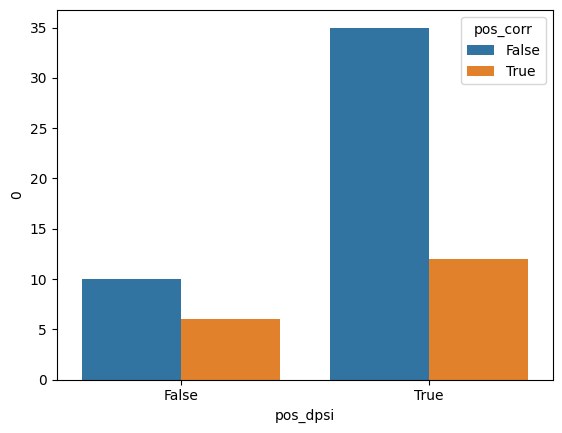

In [6]:
x = X.loc[X["abs_correlation"]>0.2].dropna().groupby(["pos_dpsi","pos_corr"]).size().reset_index()
print(x)
sns.barplot(data=x, x="pos_dpsi", y=0, hue="pos_corr")
plt.show()

## We have a Simpson-Paradox situation - Pairwise associations are not enough to correctly infer the sign

![simpsons_paradox](https://149695847.v2.pressablecdn.com/wp-content/uploads/2018/12/simpsons-paradox.jpg)

In [7]:
avail_events = set(re_psi.index).intersection(gt_regulons.loc[(gt_regulons["GENE"]==gene_oi_symbol),"EVENT"])
corrs = re_psi.loc[avail_events].corrwith(re_genexpr.loc[gene_oi_ensembl], method="spearman", axis=1)

/home/miquel/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


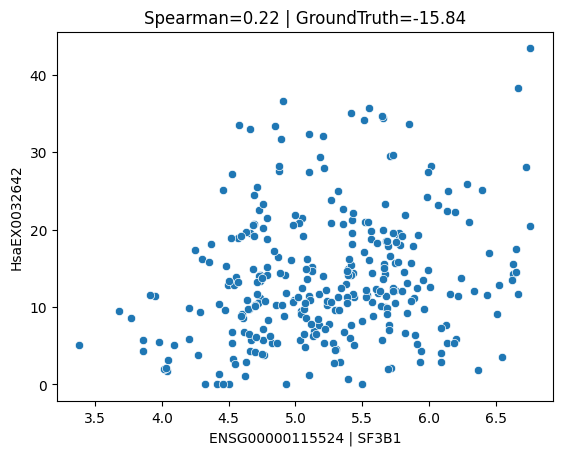

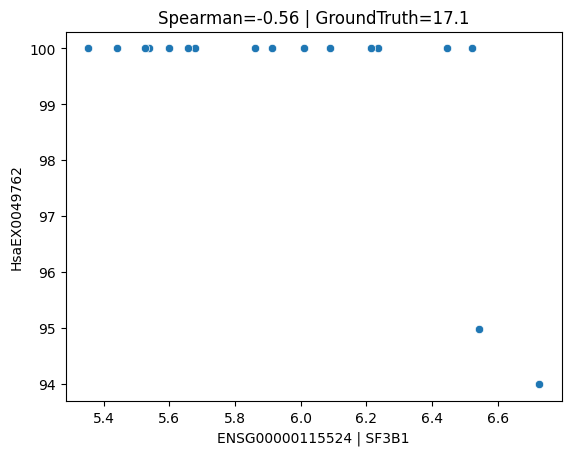

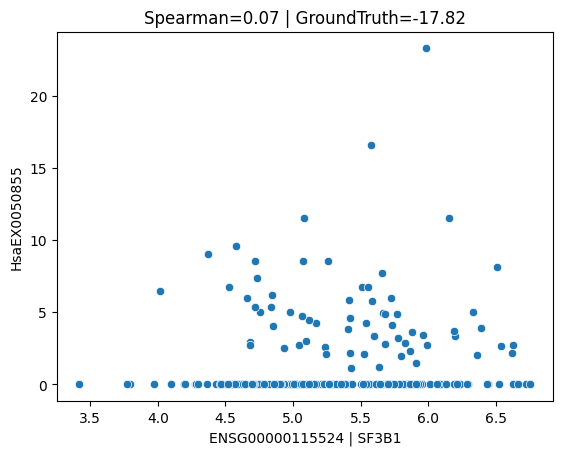

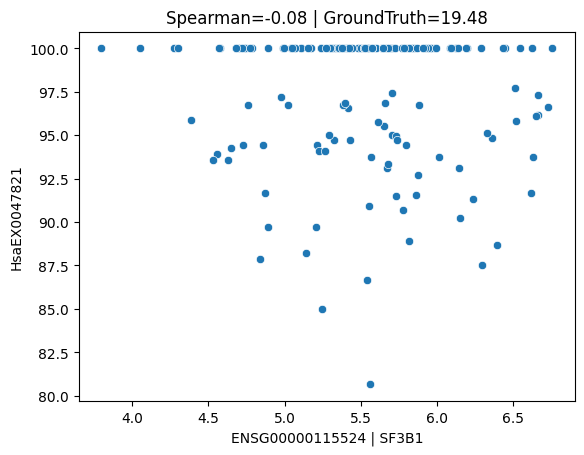

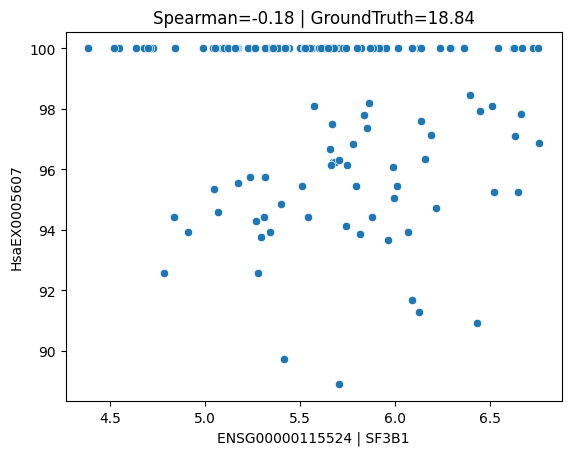

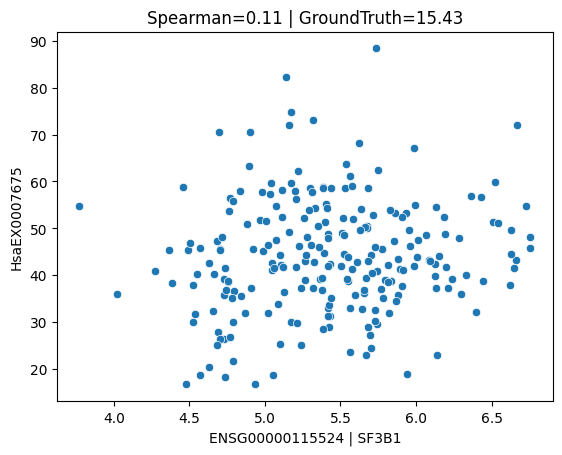

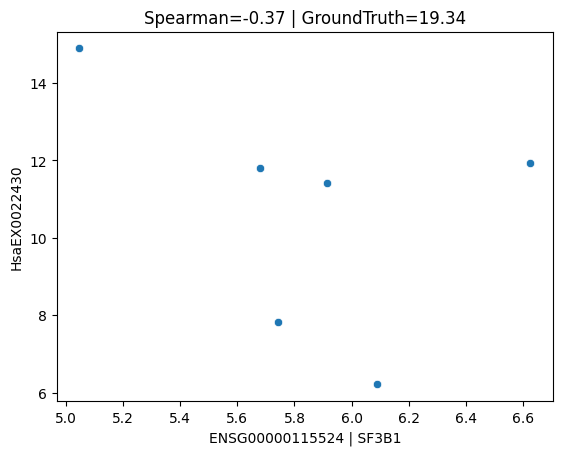

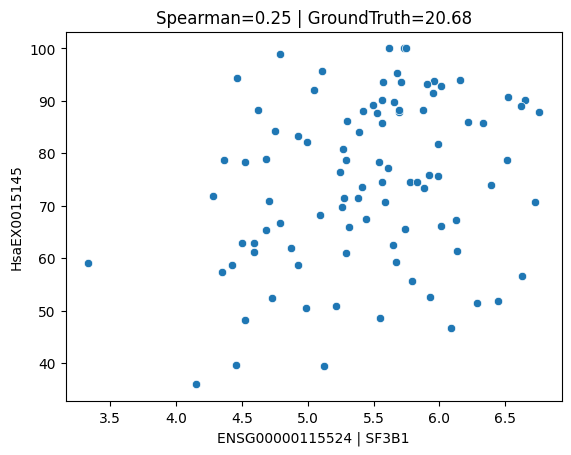

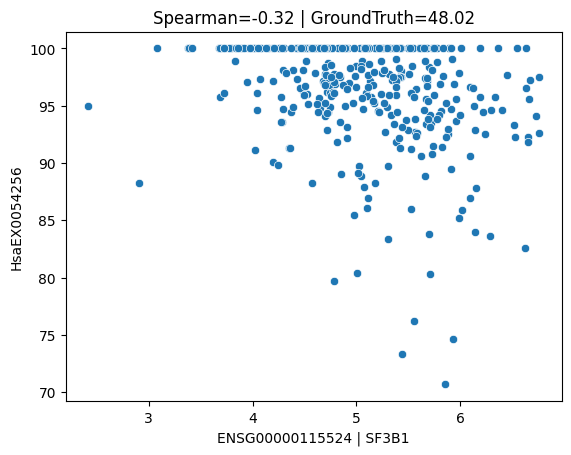

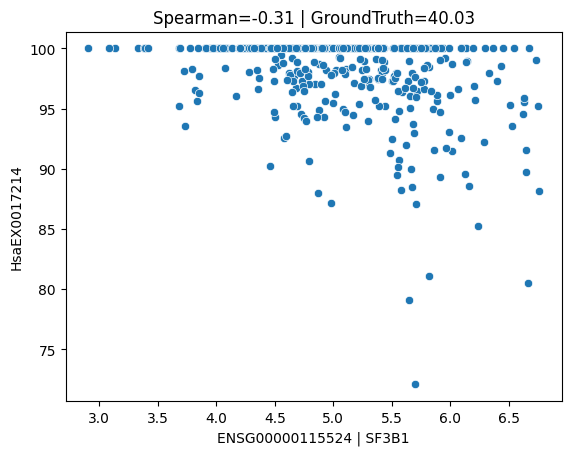

In [8]:
for event_oi in np.array(list(avail_events))[:10]:
    sns.scatterplot(x=re_genexpr.loc[gene_oi_ensembl], y=re_psi.loc[event_oi])
    plt.xlabel("%s | %s" % (gene_oi_ensembl, gene_oi_symbol))
    plt.ylabel(event_oi)
    plt.title("Spearman=%s | GroundTruth=%s" % (
            np.round(corrs[event_oi],2), 
            np.round(-gt_regulons.loc[
                (gt_regulons["GENE"]==gene_oi_symbol) & (gt_regulons["EVENT"]==event_oi),
                "delta_psi-EX"
            ].values[0],2)
        )
    )
    plt.show()

## This may be caused by coordinated changes in splicing factors across samples that differ from the changes caused by KD the SF

## Out datasets represent the observed changes in expression of SF upon KD

In [9]:
gt_kd_samples = gt_metadata.loc[(gt_metadata["PERT_GENE"]==gene_oi_symbol) & (gt_metadata["cell_line"]==cell_line_gt_oi),"sampleID"].values
gt_ctl_samples = np.unique(sum(gt_metadata.loc[(gt_metadata["PERT_GENE"]==gene_oi_symbol) & (gt_metadata["cell_line"]==cell_line_gt_oi),"control_samples"].str.split(",").values,[]))

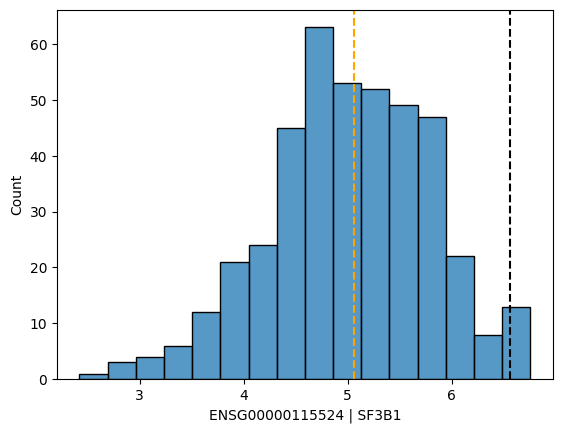

In [10]:
gt_kd_genexpr = gt_genexpr.loc[gene_oi_ensembl,gt_kd_samples].median()
gt_ctl_genexpr = gt_genexpr.loc[gene_oi_ensembl,gt_ctl_samples].median()
sns.histplot(x=re_genexpr.loc[gene_oi_ensembl])
plt.axvline(x=gt_kd_genexpr, color="orange", linestyle="dashed")
plt.axvline(x=gt_ctl_genexpr, color="black", linestyle="dashed")
plt.xlabel("%s | %s" % (gene_oi_ensembl, gene_oi_symbol))
plt.show()

## However, the rest of SFs change the expression very differently than the KD if we "simulate" it

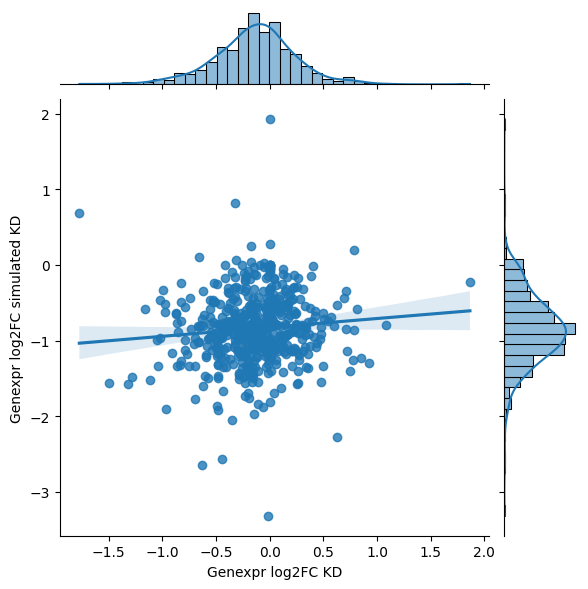

Spearman = 0.11966611205597445
Pearson = 0.09368405153089493


In [11]:
n_samples = 10

# get samples with gene expression close to controls
samples_low = np.abs(re_genexpr.loc[gene_oi_ensembl] - gt_kd_genexpr).sort_values().head(n_samples).index
samples_high = np.abs(re_genexpr.loc[gene_oi_ensembl] - gt_ctl_genexpr).sort_values().head(n_samples).index

if any(samples_low == samples_high):
    samples_low = re_genexpr.loc[gene_oi_ensembl].sort_values().head(n_samples).index
    samples_high = re_genexpr.loc[gene_oi_ensembl].sort_values().tail(n_samples).index

# compute log FC (simulate KDs)
median_genexpr_high = re_genexpr[samples_high].median(axis=1)
median_genexpr_low = re_genexpr[samples_low].median(axis=1)
kd_simulated = median_genexpr_low - median_genexpr_high

# combine
X = pd.merge(
    gt_fc_genexpr.loc[gt_fc_genexpr.index.isin(regulators_oi), gene_oi_ensembl].reset_index().rename(columns={gene_oi_ensembl:"kd_fc"}),
    kd_simulated.loc[kd_simulated.index.isin(regulators_oi)].reset_index().rename(columns={0:"kd_sim_fc"}), 
    on="ID", how="inner"
)

sns.jointplot(data=X, x="kd_fc", y="kd_sim_fc", kind="reg")
plt.xlabel("Genexpr log2FC KD")
plt.ylabel("Genexpr log2FC simulated KD")
plt.show()
print("Spearman =", X["kd_fc"].corr(X["kd_sim_fc"], method="spearman"))
print("Pearson =", X["kd_fc"].corr(X["kd_sim_fc"], method="pearson"))

## Consequently, also changes in splicing match poorly

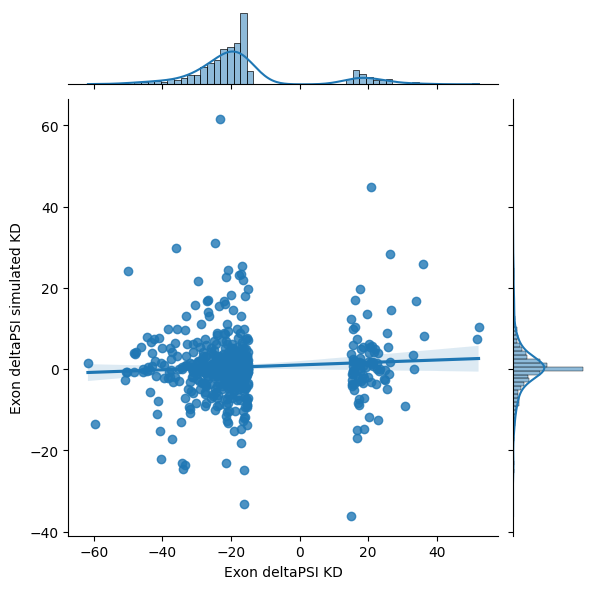

Spearman = 0.01940508845227213
Pearson = 0.06761778588350927


In [12]:
# compute delta PSI
median_psi_high = re_psi[samples_high].median(axis=1)
median_psi_low = re_psi[samples_low].median(axis=1)
kd_simulated = median_psi_low - median_psi_high

# combine
X = pd.merge(
    gt_delta_psi.loc[gt_delta_psi.index.isin(avail_events), gene_oi_ensembl].reset_index().rename(columns={gene_oi_ensembl:"kd_fc"}),
    kd_simulated.loc[kd_simulated.index.isin(avail_events)].reset_index().rename(columns={0:"kd_sim_fc"}), 
    on="EVENT", how="inner"
)

sns.jointplot(data=X, x="kd_fc", y="kd_sim_fc", kind="reg")
plt.xlabel("Exon deltaPSI KD")
plt.ylabel("Exon deltaPSI simulated KD")
plt.show()
print("Spearman =", X["kd_fc"].corr(X["kd_sim_fc"], method="spearman"))
print("Pearson =", X["kd_fc"].corr(X["kd_sim_fc"], method="pearson"))

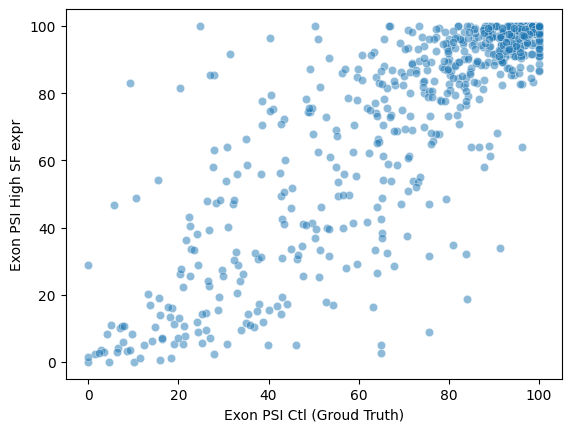

In [13]:
sns.scatterplot(x=gt_psi.loc[avail_events, gt_ctl_samples].median(axis=1), y=median_psi_high.loc[avail_events], alpha=0.5)
plt.xlabel("Exon PSI Ctl (Groud Truth)")
plt.ylabel("Exon PSI High SF expr")
plt.show()

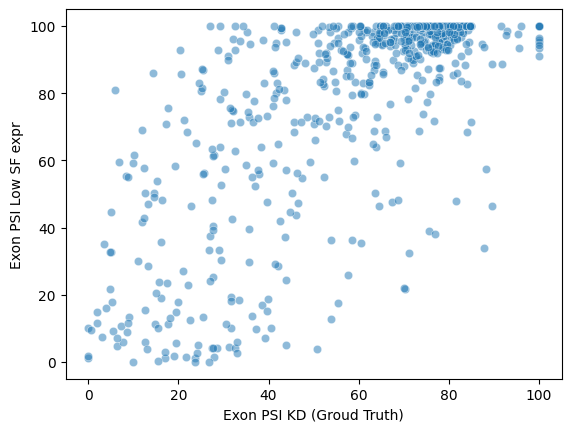

In [14]:
sns.scatterplot(x=gt_psi.loc[avail_events, gt_kd_samples].median(axis=1), y=median_psi_low.loc[avail_events], alpha=0.5)
plt.xlabel("Exon PSI KD (Groud Truth)")
plt.ylabel("Exon PSI Low SF expr")
plt.show()

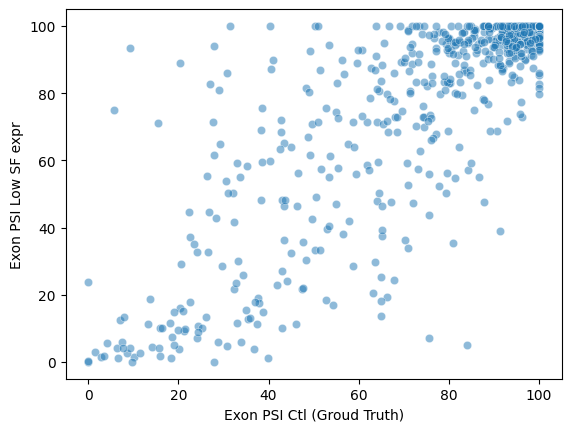

In [15]:
sns.scatterplot(x=gt_psi.loc[avail_events, gt_ctl_samples].median(axis=1), y=median_psi_low.loc[avail_events], alpha=0.5)
plt.xlabel("Exon PSI Ctl (Groud Truth)")
plt.ylabel("Exon PSI Low SF expr")
plt.show()

## Why do we have such a poor performance?
### - Daniel Moakley (Zhang lab) recovered good networks from mouse brain single cell data (SmartSeq) --> changes in gene expression may originate from changes in cell subpopulations (for bulk data)
### - observational data is not the same as interventional/causal data
### - we need to consider other factors in regulator-target associations (e.g. the interplay among splicing factors)


## Multivariate linear regression improves things

In [16]:
import statsmodels.api as sm

In [17]:
# fit models
other_events = set(re_psi.index) - avail_events
results = []
for event_oi in list(avail_events)+list(other_events)[:2000]:
    # prepare inputs
    X = re_genexpr.loc[re_genexpr.index.isin(regulators_oi)].dropna().T
    y = re_psi.loc[event_oi]

    is_missing = X.isnull().any(axis=1) | y.isnull()
    X = X.loc[~is_missing]
    y = y[~is_missing]

    X = X - X.median(axis=0).values.reshape(1,-1)
    X["intercept"] = 1
    
    if X.shape[0] < 10: continue
    
    # Fit the linear regression model
    model_full = sm.OLS(y, X).fit()
    idx = X.columns==gene_oi_ensembl
    model_null = sm.OLS(y, X.loc[:,~idx]).fit()
    lr_stat, lr_pvalue, lr_df_diff = model_full.compare_lr_test(model_null)
    
    # save
    result = {
        "EVENT": event_oi,
        "assoc_coef": model_full.params[gene_oi_ensembl],
        "lr_pvalue": lr_pvalue
    }
    results.append(result)
    
results = pd.DataFrame(results)

/home/miquel/miniconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/miquel/miniconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:2337: RuntimeWarning: invalid value encountered in double_scalars
  lrstat = -2*(llf_restr - llf_full)


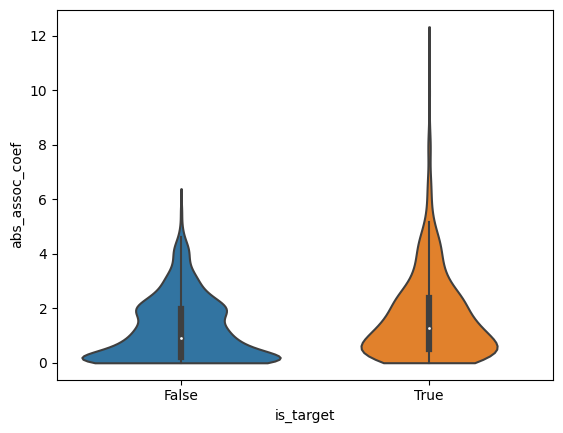

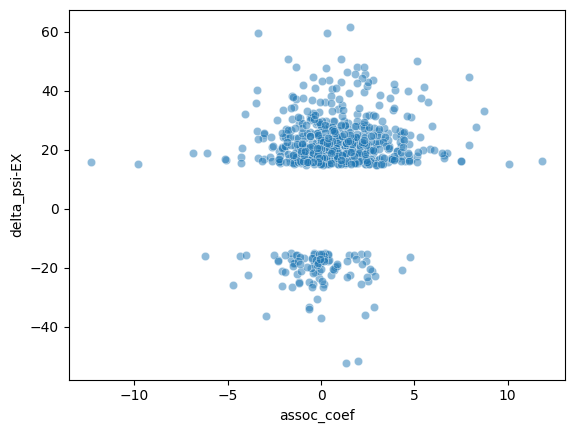

In [22]:
X = results
X["is_target"] = X["EVENT"].isin(gt_regulons["target"])
X["abs_assoc_coef"] = np.abs(X["assoc_coef"])
X = pd.merge(X, gt_regulons.loc[gt_regulons["GENE"]==gene_oi_symbol, ["EVENT","delta_psi-EX"]], on="EVENT", how="left")
X["delta_psi-EX"] = -X["delta_psi-EX"]
X["pos_coef"] = X["assoc_coef"]>0
X["pos_dpsi"] = X["delta_psi-EX"]>0

sns.violinplot(data=X, x="is_target", y="abs_assoc_coef", cut=0)
plt.show()
sns.scatterplot(data=X, x="assoc_coef", y="delta_psi-EX", alpha=0.5)
plt.show()

   pos_dpsi  pos_coef    0
0     False     False   58
1     False      True   40
2      True     False  214
3      True      True  369


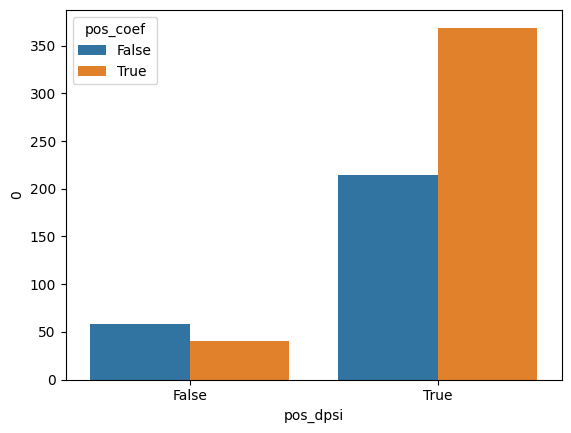

In [23]:
x = X.loc[X["is_target"] & ~X["delta_psi-EX"].isnull()].groupby(["pos_dpsi","pos_coef"]).size().reset_index()
print(x)
sns.barplot(data=x, x="pos_dpsi", y=0, hue="pos_coef")
plt.show()

## Random Forest regression does not help much

In [167]:
from sklearn.ensemble import RandomForestRegressor
from scipy import stats

In [168]:
# # Set the random seed for reproducibility
# np.random.seed(1234)
# idx_random = np.array([np.random.choice(np.arange(0, X_mor.shape[0]), X_mor.shape[0], replace=False) for col in range(X_mor.shape[1]-1)]).T
# X_mor.values[:,~idx] = X_mor.values[:,~idx].flatten()[idx_random.flatten()].reshape(X_mor.values[:,~idx].shape)

In [169]:
def randomize_arr(original_array):
    original_array = original_array.copy()

    # Randomize each column independently
    randomized_array = np.empty_like(original_array)

    for i in range(original_array.shape[1]):
        np.random.seed(i)  # Set seed based on column index
        random_indices = np.random.permutation(original_array.shape[0])
        randomized_array[:, i] = original_array[random_indices, i]
    
    return randomized_array

In [170]:
# fit models
other_events = set(re_psi.index) - avail_events
results = []
for event_oi in (list(avail_events)+list(other_events)[:2000]):
    # prepare inputs
    X = re_genexpr.loc[re_genexpr.index.isin(regulators_oi)].dropna().T
    y = re_psi.loc[event_oi]

    is_missing = X.isnull().any(axis=1) | y.isnull()
    X = X.loc[~is_missing]
    y = y[~is_missing]

    X = X - X.median(axis=0).values.reshape(1,-1)
    
    if X.shape[0] < 10: continue
    
    # Fit the regression model
    model = RandomForestRegressor(n_estimators=10, min_samples_split=5, random_state=1234, n_jobs=10)
    model.fit(X, y)

    idx = X.columns==gene_oi_ensembl
    X_mor = X.copy()
    # (randomize instead) X_mor.values[:,~idx] = 0
    X_mor.values[:,:] = randomize_arr(X_mor.values)
    X_mor.values[:,idx] = X.values[:,idx]
    y_pred = model.predict(X_mor)
    
    assoc_coef_orig, pvalue = stats.spearmanr(X.values[:,idx].ravel(), y)
    assoc_coef_rf, pvalue = stats.spearmanr(X.values[:,idx].ravel(), y_pred)
    
    # save
    result = {
        "EVENT": event_oi,
        "assoc_coef_orig": assoc_coef_orig,
        "assoc_coef_rf": assoc_coef_rf
    }
    results.append(result)
    
results = pd.DataFrame(results)

/home/miquel/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/miquel/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/miquel/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/miquel/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/miquel/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:448

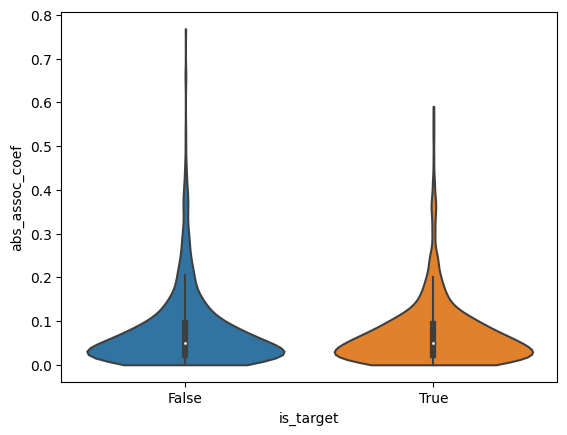

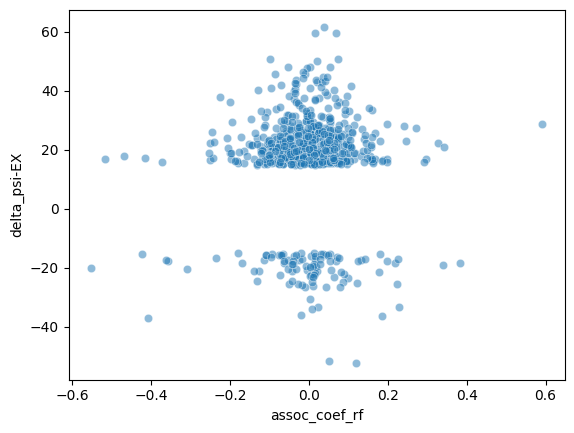

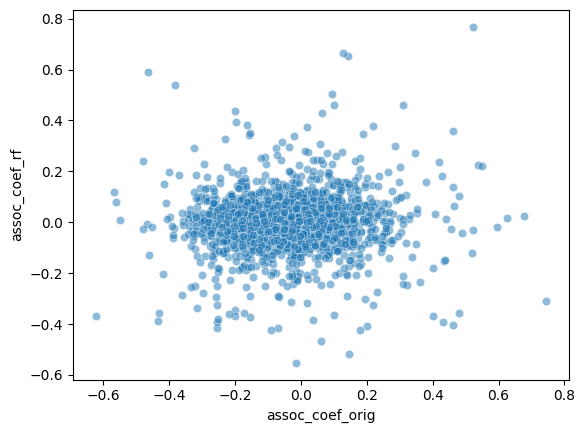

In [173]:
X = results
X["is_target"] = X["EVENT"].isin(gt_regulons["target"])
X["abs_assoc_coef"] = np.abs(X["assoc_coef_rf"])
X = pd.merge(X, gt_regulons.loc[gt_regulons["GENE"]==gene_oi_symbol, ["EVENT","delta_psi-EX"]], on="EVENT", how="left")
X["delta_psi-EX"] = -X["delta_psi-EX"]
X["pos_coef"] = X["assoc_coef_rf"]>0
X["pos_dpsi"] = X["delta_psi-EX"]>0

sns.violinplot(data=X, x="is_target", y="abs_assoc_coef", cut=0)
plt.show()
sns.scatterplot(data=X, x="assoc_coef_rf", y="delta_psi-EX", alpha=0.5)
plt.show()
sns.scatterplot(data=results, x="assoc_coef_orig", y="assoc_coef_rf", alpha=0.5)
plt.show()

   pos_dpsi  pos_coef    0
0     False     False   44
1     False      True   54
2      True     False  280
3      True      True  303


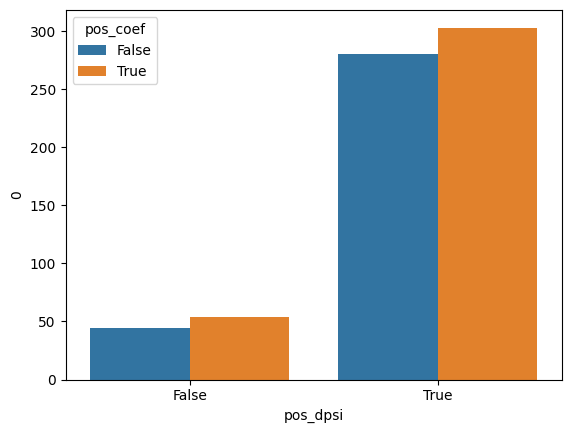

In [172]:
x = X.loc[X["is_target"] & ~X["delta_psi-EX"].isnull() & ~X["assoc_coef_rf"].isnull()].groupby(["pos_dpsi","pos_coef"]).size().reset_index()
print(x)
sns.barplot(data=x, x="pos_dpsi", y=0, hue="pos_coef")
plt.show()